# Assignment 8

*EE2703: Applied Programming  
Author: Varun Sundar, EE16B068* 

# Abstract

This week's assignment involves the analysis of active filter's using laplce transforms. Python's symbolic solving library, sympy, comes off as a particularly nifty tool to handle our requirements in solving Modified Nodal Analysis (MNA) equations. Besides this the library also includes useful classes to handle the simulation and response to inputs. 

Coupled with _scipy's signal_ module, we are able to analyse both Sallen-Key and Raunch filters, two common active filter topologies to attain second order filters with just a single operational amplifier.

# Introduction

Reference to Horowitz and Hill (Active Filters) : [link](https://artofelectronics.net/)

We begin by understanding the usage of sympy in defining, evaluating and plotting symbolic equations. Besides this, we also examine the use case of matrix equation for MNA solutions. With this, we start analysing the case of an active low pass filter.

Conventions:
1. We are using Python 3, GCC for C 
2. Underscore naming vs Camel Case 
3. PEP 25 convention style.


In [216]:
import sympy
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sp

# Use either

sympy.init_session
#sympy.init_printing(use_unicode=True)
sympy.init_printing(use_latex='mathjax')

Here, we use sympy's lambdify method to plot the Bode Plot of the transfer function,
$$ H(s) = 1/(s^3+2*s^2+2s+1) $$

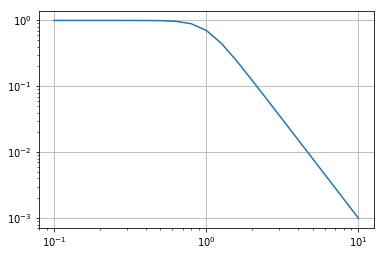

In [217]:
s=sympy.symbols('s')
h=1/(s**3+2*s**2+2*s+1)
w=np.logspace(-1,1,21)
ss=1j*w
f=sympy.lambdify(s,h,"numpy")

plt.loglog(w,np.abs(f(ss)))
plt.grid(True)
plt.show()

We solve for an active low pass filter (Sallen-Key). This particular active filter is known for being a single op-amp based low pass filter.

The MNA (Nodal) Equations may be recast as:

$$
\begin{bmatrix}
   0& 0& 1& -1/G\\   
   −\frac{1}{1+s R_2 C_2}& 1& 0& 0&\\
   0& −G& G& 1&\\
   -1/R_1-1/R_2-sC_1& 1/R_2& 0& sC_1&
   \end{bmatrix}
   *
   \begin{bmatrix} V_1 \\ V_p \\ V_m\\ V_o \end{bmatrix}
   =
   \begin{bmatrix} 0\\ 0\\ 0\\ V_i(s)/R \end{bmatrix}
$$

Note that the lab assignment sheet used,

$$ V_o=G(V_p −V_m) $$

incorrectly, since the op-amp is a large gain device. This should be replaced by:

$$ V_o=G(V_p) $$ which correctly replaces the intended gain block.

In [218]:
def lowpass(R1,R2,C1,C2,G,Vi):
    s=sympy.symbols('s')
    A=sympy.Matrix([[0,0,1,-1/G],[-1/(1+s*R2*C2),1,0,0], \
    [0,-G,0,1],[-1/R1-1/R2-s*C1,1/R2,0,s*C1]])
    b=sympy.Matrix([0,0,0,Vi/R1])
    V=A.inv()*b
    return (A,b,V)

G=1000
Computed Inverse


                            0.0001586                            
─────────────────────────────────────────────────────────────────
               ⎛             1.586e-9⋅s                0.0001   ⎞
(1.0e-5⋅s + 1)⋅⎜-1.0e-9⋅s + ──────────── - 0.0002 + ────────────⎟
               ⎝            1.0e-5⋅s + 1            1.0e-5⋅s + 1⎠

Simplified Expression


          -0.0001586            
────────────────────────────────
         2                      
1.0e-14⋅s  + 1.414e-9⋅s + 0.0001

-8.91551071878941e-6

[-6.30517023959647e-11, -8.91551071878941e-6, -0.630517023959647]

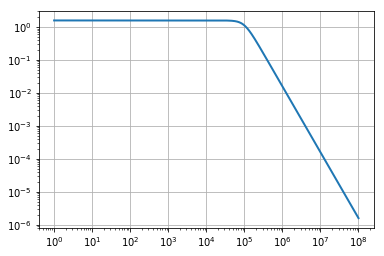

In [219]:
A,b,V=lowpass(10000,10000,1e-9,1e-9,1.586,1)

print ('G=1000')
Vo=V[3]
# Computed inverse
print ("Computed Inverse")
display(Vo)
# Simplify existing expression
print ("Simplified Expression")
Vo=sympy.simplify(Vo)
display(Vo)

s=sympy.symbols('s')
display((1/Vo).coeff(s))

a=sympy.Poly(1/Vo,s)
display(a.all_coeffs())

w=np.logspace(0,8,801)
ss=1j*w
hf=sympy.lambdify(s,Vo,"numpy")
v=hf(ss)

plt.loglog(w,abs(v),lw=2)
plt.grid(True)
plt.show()

# Assignment Questions

## Question 1

To obtain the step response of the circuit, we do so in the laplace domain and then convert it to the time domain.

In [220]:
H=Vo*1/s
display(H)
H=sympy.simplify(H)
print (" Simplified Expression ")
display(H)

            -0.0001586              
────────────────────────────────────
  ⎛         2                      ⎞
s⋅⎝1.0e-14⋅s  + 1.414e-9⋅s + 0.0001⎠

 Simplified Expression 


            -0.0001586              
────────────────────────────────────
  ⎛         2                      ⎞
s⋅⎝1.0e-14⋅s  + 1.414e-9⋅s + 0.0001⎠

We compute the time-domain response of the active low pass filter.

G=1000


          -0.0001586            
────────────────────────────────
         2                      
1.0e-14⋅s  + 1.414e-9⋅s + 0.0001

[-0.0001586] [  1.00000000e-14   1.41400000e-09   1.00000000e-04]


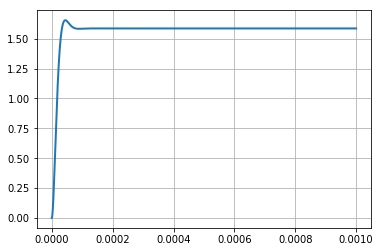

In [237]:
A,b,V=lowpass(10000,10000,1e-9,1e-9,1.586,1)

print ('G=1000')
Vo=V[3]
Vo=sympy.simplify(Vo)
display(Vo)

s,t=sympy.symbols("s t")
t=sympy.Symbol("t",positive=True)
n,d = sympy.fraction(Vo)
n_sp,d_sp=(np.array(sympy.Poly(j,s).all_coeffs(),dtype=float) for j in (n,d))

print(n_sp,d_sp)
ts=np.linspace(0,0.001,8001)
t,x,svec=sp.lsim(sp.lti(n_sp,d_sp),np.ones(len(ts)),ts)
# Plot the absolute step response
plt.plot(t,np.abs(x),lw=2)
plt.grid(True)
plt.show()

## Question 2

Here, the input is  
$$ v_i(t) =  (sin(2000\pi t)+cos (2*10^6 \pi t))u(t)$$ Volts  

We need to determine the output voltage $v_0(t)$.

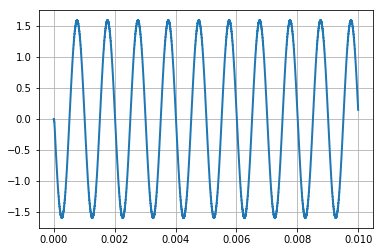

In [222]:
n,d = sympy.fraction(Vo)
n_sp,d_sp=(np.array(sympy.Poly(j,s).all_coeffs(),dtype=float) for j in (n,d))

# Function to simulate
ts=np.linspace(0,0.01,8001)
vi= np.sin(2000*np.pi*ts)+np.cos(2*10**6*np.pi*ts)

t,x,svec=sp.lsim(sp.lti(n_sp,d_sp),vi,ts)
# Plot the lamdified values
plt.plot(t,x,lw=2)
plt.grid(True)
plt.show()

Given that this is a low pass filter, we expect attenuated sinusoids as outputs (which is indeed the case). Also, note that the component due to a frequency of $10^6 Hz$ is nearly attenutated out.

To visualise this, we vary the frequency of the cosine component from $10^3$ to $10^4$ Hertz.

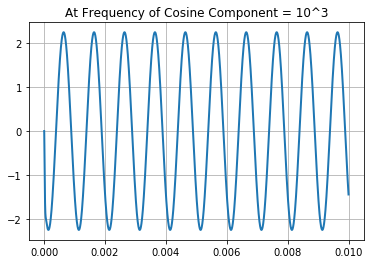

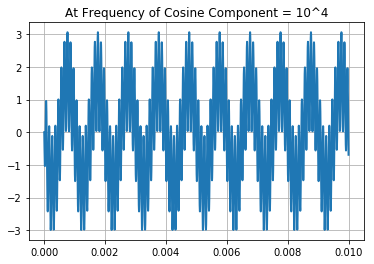

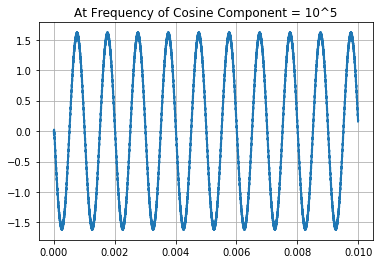

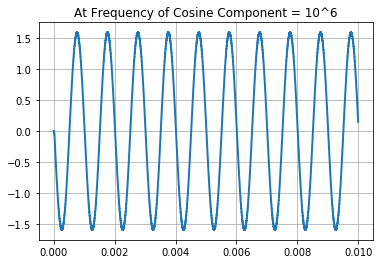

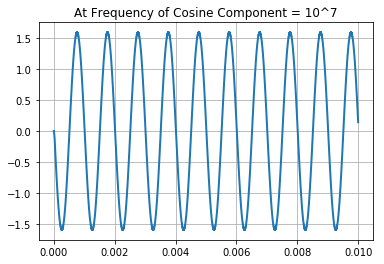

In [223]:
n,d = sympy.fraction(Vo)
n_sp,d_sp=(np.array(sympy.Poly(j,s).all_coeffs(),dtype=float) for j in (n,d))

n=[3,4,5,6,7]
for i in n:
    # Function to simulate
    ts=np.linspace(0,0.01,8001)
    vi= np.sin(2000*np.pi*ts)+np.cos(2*10**i*np.pi*ts)

    t,x,svec=sp.lsim(sp.lti(n_sp,d_sp),vi,ts)
    # Plot the lamdified values
    plt.plot(t,x,lw=2)
    plt.grid(True)
    plt.title("At Frequency of Cosine Component = 10^"+str(i))
    plt.show()

## Question 3

We now solve for an active low pass filter (Rauch). This particular active filter is known for being a single op-amp based high pass filter.

The MNA (Nodal) Equations may be recast as:

$$
\begin{bmatrix}
   s(C_1+C_2) + 1/R_1& 0& -sC_2& -1/R_1\\   
   0& G& 0 &-1\\
   -sC_2& 0& 1/R_3 + sC_2& 0&\\
   0& -G& G& 1&
   \end{bmatrix}
   *
   \begin{bmatrix} V_1 \\ V_p \\ V_m\\ V_o \end{bmatrix}
   =
   \begin{bmatrix} sC_1V_i\\ 0\\ 0\\ 0 \end{bmatrix}
$$

In [224]:
def highpass(R1,R2,C1,C2,G,Vi):
    s=sympy.symbols('s')
    A=sympy.Matrix([[s*(C1+C2)+1/R1,0,-s*C2,-1/R1],[0,G,0,-1], \
    [-s*C2,0,1/R2+s*C2,0],[0,0,-G,1]])
    b=sympy.Matrix([Vi*s*C1,0,0,0])
    V=A.inv()*b
    return (A,b,V)

G=1000
Vo (transfer function)


                                      2                           
                          -1.586e-18⋅s                            
──────────────────────────────────────────────────────────────────
         2                                                        
1.0e-18⋅s  + 1.586e-13⋅s - (1.0e-9⋅s + 0.0001)⋅(2.0e-9⋅s + 0.0001)

Vo (transfer function) Simplified


                           2                
                1.586e-18⋅s                 
────────────────────────────────────────────
         2                                  
1.0e-18⋅s  + 1.41400000000001e-13⋅s + 1.0e-8

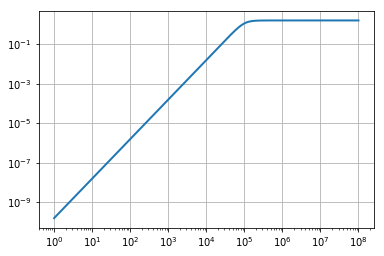

In [225]:
A,b,V=highpass(10000,10000,1e-9,1e-9,1.586,1)

print ('G=1000')
Vo=V[3]
print("Vo (transfer function)")
display(Vo)
Vo=sympy.simplify(Vo)
print("Vo (transfer function) Simplified")
display(Vo)
w=np.logspace(0,8,801)
ss=1j*w
hf=sympy.lambdify(s,Vo,"numpy")
v=hf(ss)

plt.loglog(w,abs(v),lw=2)
plt.grid(True)
plt.show()

Clearly, the Rauch filter acts as a second order high pass filter.

## Question 4

We now obtain the response of the circuit to a damped sinusoid.

Let us start with a damping coefficient of $0.01 s^{-1}$, and a frequency of $10^{3} Hertz$, and sweep the frequency.

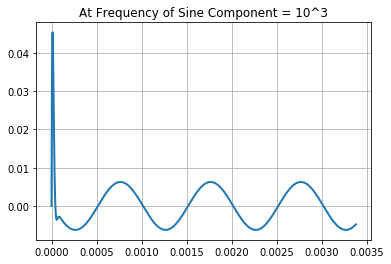

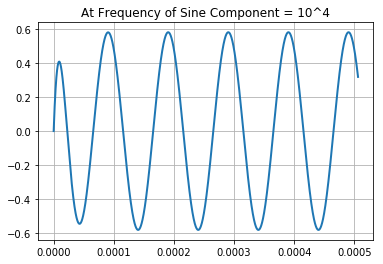

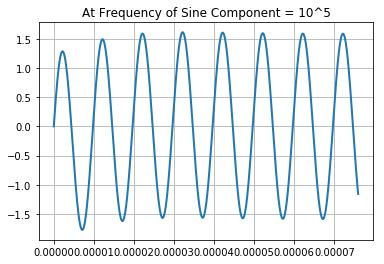

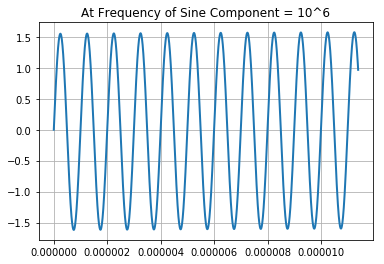

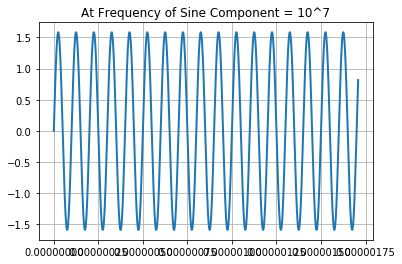

In [226]:
n,d = sympy.fraction(Vo)
n_sp,d_sp=(np.array(sympy.Poly(j,s).all_coeffs(),dtype=float) for j in (n,d))

n=[3,4,5,6,7]
for i in n:
    # Function to simulate
    ts=np.linspace(0,0.15**i,8001)
    vi= np.exp(-0.05*ts)*np.sin(2*10**i*np.pi*ts)

    t,x,svec=sp.lsim(sp.lti(n_sp,d_sp),vi,ts)
    plt.title("At Frequency of Sine Component = 10^"+str(i))
    # Plot the lamdified values
    plt.plot(t,x,lw=2)
    plt.grid(True)
    plt.show()

Note that for brevity, we have changed the time-axis as the frequency keeps increasing. More importantly, notice that the gain of the circuit increases with frequency, a characteristic of high pass filters.

## Question 5

We now obtain the response of the circuit to a unit step function.

[  1.58600000e-18   0.00000000e+00   0.00000000e+00] [  1.00000000e-18   1.41400000e-13   1.00000000e-08]


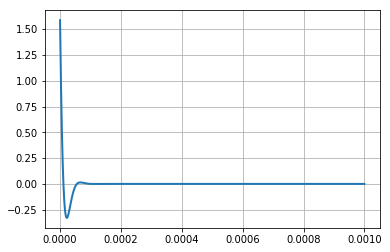

In [227]:
s,t=sympy.symbols("s t")
t=sympy.Symbol("t",positive=True)
n,d = sympy.fraction(Vo)
n_sp,d_sp=(np.array(sympy.Poly(j,s).all_coeffs(),dtype=float) for j in (n,d))

print(n_sp,d_sp)
ts=np.linspace(0,0.001,8001)
t,x,svec=sp.lsim(sp.lti(n_sp,d_sp),np.ones(len(ts)),ts)
# Plot the lamdified values
plt.plot(t,x,lw=2)
plt.grid(True)
plt.show()

# Results and Discussion

We have analysed the working of both Sallen-Key (low pass) and Rauch (high pass) filters. This has been done by studying the step response as well as reponse to sinusoids.

In the former case, we noted the following:

1. The low pass filter reponse has an initial value greater than the steady state response, which indicates a quality factor $(Q>1)$.

2. Similarly, the high pass filter reponse has an initial value lesser than the steady state response, which indicates a quality factor $(Q>1)$.

3. In the case of a low pass filter, we noticed that higher harmonics get attenuated as compared to lower harmonics. The converse happens in case of a high pass filter.

On the programming paradigm perspective, we observe that while scipy provides a rather good amount of dexterity with symbolic expressions, the lack of compatibility with scipy poses a major rethink in problem solving approaches. There is certain amount of cross usage aided by lambda objects, however, these are costly solutions.

In our case, we use to strength the fact that the transfer functions are rational and second order. This helps us extract coefficients and pipeline efficiently into the signal processing library of scipy.